In [2]:
# Initialize Otter
import otter
grader = otter.Notebook("lab11.ipynb")

# Lab 11 Decision Trees and Random Forests

In this assignment, we will have you train a multi-class classifier with three different models (one-vs-rest logistic regression, decision tree, random forest) and compare the accuracies and decision boundaries created by each. We'll be looking at a dataset of per-game stats for all NBA players in the 2018-19 season. This dataset comes from [basketball-reference.com](https://www.basketball-reference.com/).

### Due Date

This assignment is due on **Saturday, July 31st at 11:59 pm PDT.**

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

### Lab Walkthrough Video

In addition to the lab notebook, we have also released a prerecorded walk-through video of the lab. We encourage you to reference this video as you work through the lab. Run the cell below to display the video.

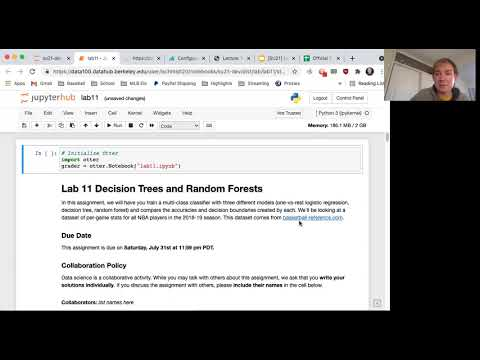

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo("K9iWroWKAVo", list = 'PLQCcNQgUcDfpZ1FqfNkS_uzlUkY-RJysT', listType = 'playlist')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

In [5]:
nba_data = pd.read_csv("nba18-19.csv")
nba_data.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


Our goal will be to predict a player's position given several other features. The 5 positions in basketball are PG, SG, SF, PF, and C (which stand for point guard, shooting guard, small forward, power forward, and center). This information is contained in the `Pos` column.

In [6]:
nba_data['Pos'].value_counts()

SG       176
PF       147
PG       139
C        120
SF       118
PF-SF      2
SF-SG      2
SG-SF      1
PF-C       1
C-PF       1
SG-PF      1
Name: Pos, dtype: int64

While we could set out to try and perform 5-class classification, the results (and visualizations) are slightly more interesting if we try and categorize players into 1 of 3 categories: **guard**, **forward**, and **center**. The below code will take the `Pos` column of our dataframe and use it to create a new column `Pos3` that consist of values G, F, and C (which stand for guard, forward, and center).

In [7]:
def basic_position(pos):
    if 'F' in pos:
        return 'F'
    elif 'G' in pos:
        return 'G'
    return 'C'

nba_data['Pos3'] = nba_data['Pos'].apply(basic_position)
nba_data['Pos3'].value_counts()

G    315
F    273
C    120
Name: Pos3, dtype: int64

Furthermore, since there are **many** players in the NBA (in the 2018-19 season there were 530 unique players), our visualizations can get noisy and messy. Let's restrict our data to only contain rows for players that averaged 10 or more points per game.

In [8]:
nba_data = nba_data[nba_data['PTS'] > 10]

Now, let's look at a scatterplot of Rebounds (`TRB`) vs. Assists (`AST`).

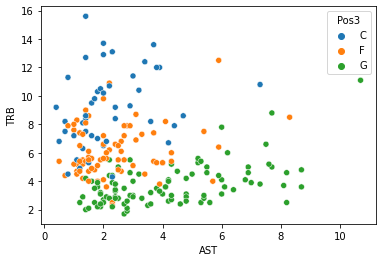

In [9]:
sns.scatterplot(data = nba_data, x = 'AST', y = 'TRB', hue = 'Pos3');

As you can see, when using just rebounds and assists as our features, we see pretty decent cluster separation. That is, Centers, Forwards, and Guards appear in different regions of the plot.

## Question 1: Evaluating Split Quality

We will explore different ways to evaluate split quality for classification and regression trees in this question.

### Question 1a

In lecture we defined the entropy S of a node as:

$$ S = -\sum_{C} p_C \log_{2} p_C $$

where $p_C$ is the proportion of data points in a node with label $C$. This function helped us determine the unpredictability of a node in a decision tree. 

Implement the `entropy` function, which outputs the entropy of a node with a given set of labels. The `labels` parameter is a list of labels in our dataset. For example, `labels` could be `['G', 'G', 'F', 'F', 'C', 'C']`.

<!--
BEGIN QUESTION
name: q1a
-->

In [11]:
def entropy(labels):
    counts = np.unique(labels, return_counts = True)[1]
    proportions = counts/sum(counts)
    return -np.sum(proportions * np.log2(proportions))

entropy(nba_data['Pos3'])

1.521555567956027

In [12]:
grader.check("q1a")

q1a results: All test cases passed!

### Question 1b

The decision tree visualizations in lecture contained nodes with a `gini` parameter. This depicts the node's Gini impurity, which is the chance that a sample would be misclassified if randomly assigned at this point. Gini impurity is a popular alternative to entropy for determining the best split at a node, and it is in fact the default criterion for scikit-learn's `DecisionTreeClassifier`. We can calculate the Gini impurity of a node with the formula ($p_C$ is the proportion of data points in a node with label $C$):

$$ G = 1 - \sum_{C} {p_C}^2 $$

Note that no logarithms are involved in the calculation of Gini impurity, which can make it faster to compute compared to entropy.

Implement the `gini_impurity` function, which outputs the Gini impurity of a node with a given set of labels. The `labels` parameter is defined similarly to the previous part.

<!--
BEGIN QUESTION
name: q1b
-->

In [13]:
def gini_impurity(labels):
    counts = np.unique(labels, return_counts = True)[1]
    proportions = counts/sum(counts)
    return 1 - np.sum(proportions**2)

gini_impurity(nba_data['Pos3'])

0.6383398017253514

In [14]:
grader.check("q1b")

q1b results: All test cases passed!

As an optional exercise in probability, try to think of a way to derive the formula for Gini impurity.

It usually does not make sense to use entropy and Gini impurity for regression trees because the response variable is continuous. However, we can use the variance of the response values in a node as an alternative to entropy and Gini impurity. Recall that the variance is defined as:

$$ \sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2 $$

where $\mu$ is the mean, $N$ is the total number of data points, and $x_i$ is the value of each data point.

Here we define variance as we have previously done in the course

In [15]:
def variance(values):
    return np.mean((values - np.mean(values)) ** 2)
    
variance(nba_data['PTS'])

21.023148263588652

### Question 1c

In lecture, we used weighted entropy as a loss function to help us determine the best split. Recall that the weighted entropy is given by:

$$ L = \frac{N_1 S(X) + N_2 S(Y)}{N_1 + N_2} $$

$N_1$ is the number of samples in the left node $X$, and $N_2$ is the number of samples in the right node $Y$. This notion of a weighted average can be extended to other metrics such as Gini impurity and variance simply by changing the $S$ (entropy) function to $G$ (Gini impurity) or $\sigma^2$ (variance).

First, implement the `weighted_metric` function. The `left` parameter is a list of labels or values in the left node $X$, and the `right` parameter is a list of labels or values in the right node $Y$. The `metric` parameter is a function which can be `entropy`, `gini_impurity`, or `variance`. For `entropy` and `gini_impurity`, you may assume that `left` and `right` contain discrete labels. For `variance`, you may assume that `left` and `right` contain continuous values.

Then, assign `we_pos3_age_30` to the weighted entropy (in the `Pos3` column) of a split that partitions `nba_data` into two groups: a group with players who are 30 years old or older and a group with players who are younger than 30 years old.

<!--
BEGIN QUESTION
name: q1c
-->

In [16]:
def weighted_metric(left, right, metric):
    n1, n2 = len(left), len(right)
    s1, s2 = metric(left), metric(right)
    return (n1 * s1 + n2 * s2) / (n1 + n2)

we_pos3_age_30 = weighted_metric(nba_data.loc[nba_data['Age'] >= 30, 'Pos3'], nba_data.loc[nba_data['Age'] < 30, 'Pos3'], entropy)
we_pos3_age_30

1.521489768014793

In [17]:
grader.check("q1c")

q1c results: All test cases passed!

We will not go over the entire decision tree fitting process in this assignment, but you now have the basic tools to fit a decision tree. As an optional exercise, try to think about how you would extend these tools to fit a decision tree from scratch.

## Question 2: Classification

Let's switch gears to classification with the NBA dataset.

## One-vs-Rest Logistic Regression

We only discussed binary logistic regression in class, but there is a natural extension to binary logistic regression called one-vs-rest logistic regression for multiclass classification. In essence, one-vs-rest logistic regression simply builds one binary logistic regression classifier for each of the $N$ classes (in this scenario $N = 3$). We then predict the class corresponding to the classifier that gives the highest probability among the $N$ classes.

Before using logistic regression, let's first split `nba_data` into a training set and test set.

In [18]:
nba_train, nba_test = train_test_split(nba_data, test_size=0.25, random_state=100)
nba_train = nba_train.sort_values(by='Pos')
nba_test = nba_test.sort_values(by='Pos')

### Question 2a

In the cell below, set `logistic_regression_model` to be a one-vs-rest logistic regression model. Then, fit that model using the `AST` and `TRB` columns (in that order) from `nba_train` as our features, and `Pos3` as our response variable.

Remember, [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has already been imported for you. There is an optional parameter **`multi_class`** you need to specify in order to make your model a multi-class one-vs-rest classifier. See the documentation for more details.

<!--
BEGIN QUESTION
name: q2a
-->

In [19]:
logistic_regression_model = LogisticRegression(multi_class = 'ovr')
logistic_regression_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

LogisticRegression(multi_class='ovr')

In [20]:
grader.check("q2a")

q2a results: All test cases passed!

To see our classifier in action, we can use `logistic_regression_model.predict` and see what it outputs.

In [23]:
nba_train['Predicted (OVRLR) Pos3'] = logistic_regression_model.predict(nba_train[['AST', 'TRB']])
nba_train[['AST', 'TRB', 'Pos3', 'Predicted (OVRLR) Pos3']].head(15)

Our model does decently well here, as you can see visually above. Below, we compute the training accuracy:

In [21]:
lr_training_accuracy = logistic_regression_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
lr_training_accuracy

0.7964071856287425

We can compute the test accuracy as well by looking at `nba_test` instead of `nba_train`:

In [22]:
lr_test_accuracy = logistic_regression_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
lr_test_accuracy

0.6428571428571429

Now, let's draw the decision boundary for this logistic regression classifier, and see how the classifier performs on both the training and test data.

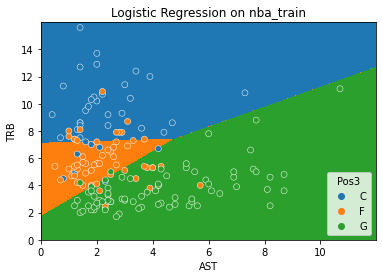

In [23]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_train');

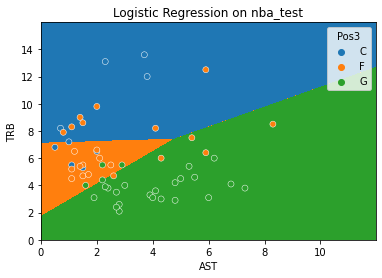

In [24]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_test');

Our one-vs-rest logistic regression was able to find a linear decision boundary between the three classes. It generally classifies centers as players with a lot of rebounds, forwards as players with a medium number of rebounds and a low number of assists, and guards as players with a low number of rebounds. 

Note: In practice we would use many more features – we only used 2 here just so that we could visualize the decision boundary.

## Decision Trees

### Question 2b

Let's now create a decision tree classifier on the same training data `nba_train`, and look at the resulting decision boundary. 

In the following cell, first, use [`tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to fit a model using the same features and response as above, and call this model `decision_tree_model`. Set the `random_state` parameter to 42. Set the criterion to be `gini`.

**Hint:** Your code will be mostly the same as the previous part.

<!--
BEGIN QUESTION
name: q2b
-->

In [25]:
decision_tree_model = tree.DecisionTreeClassifier(random_state = 42, criterion = 'gini')
decision_tree_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

DecisionTreeClassifier(random_state=42)

In [26]:
grader.check("q2b")

q2b results: All test cases passed!

Now, let's draw the decision boundary for this decision tree classifier, and see how the classifier performs on both the training and test data.

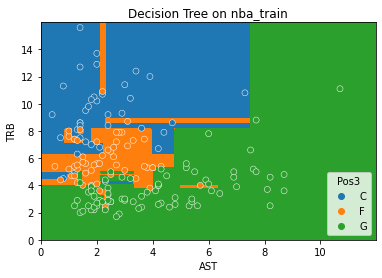

In [27]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_train');

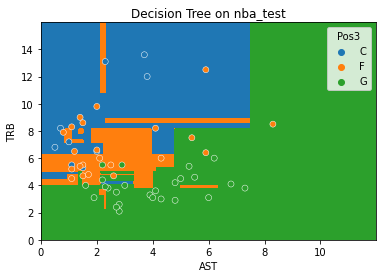

In [28]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_test');

We compute the training and test accuracies of the decision tree model below.

In [29]:
dt_training_accuracy = decision_tree_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
dt_test_accuracy = decision_tree_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
dt_training_accuracy, dt_test_accuracy

(0.9940119760479041, 0.6428571428571429)

## Random Forests

### Question 2c

Let's now create a random forest classifier on the same training data `nba_train` and look at the resulting decision boundary. 

In the following cell, use [`ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to fit a model using the same features and response as above, and call this model `random_forest_model`. Use 20 trees in your random forest classifier, and set the `random_state` parameter to 42.

**Hint:** Your code for both parts will be mostly the same as the first few parts of this question.

**Hint:** Look at the `n_estimators` parameter of `ensemble.RandomForestClassifier`.

<!--
BEGIN QUESTION
name: q2c
-->

In [33]:
random_forest_model = ensemble.RandomForestClassifier(random_state = 42, criterion = 'gini', n_estimators = 20)
random_forest_model.fit(nba_train[['AST', 'TRB']], nba_train['Pos3'])

RandomForestClassifier(n_estimators=20, random_state=42)

In [34]:
grader.check("q2c")

q2c results: All test cases passed!

Now, let's draw the decision boundary for this random forest classifier, and see how the classifier performs on both the training and test data.

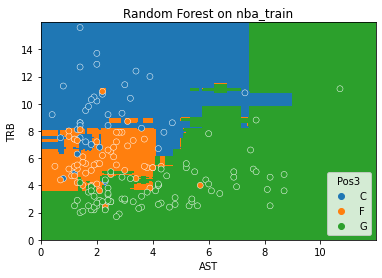

In [35]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_train');

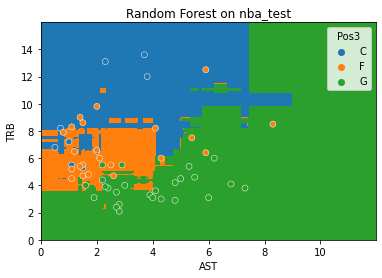

In [36]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_test');

We compute the training and test accuracies of the random forest model below.

In [37]:
rf_train_accuracy = random_forest_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
rf_test_accuracy = random_forest_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
rf_train_accuracy, rf_test_accuracy

(0.9760479041916168, 0.7142857142857143)

### Question 2d

Below is a summary of the training and test accuracies for the three models you created (multiclass one-vs-rest logistic regression, decision tree, random forest).

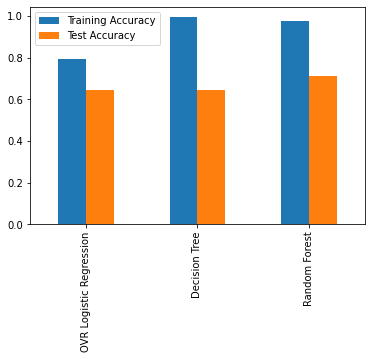

In [38]:
train_accuracy = [lr_training_accuracy, lr_test_accuracy, dt_training_accuracy, dt_test_accuracy, rf_train_accuracy, rf_test_accuracy]
index = ['OVR Logistic Regression', 'Decision Tree', 'Random Forest']
df = pd.DataFrame([(lr_training_accuracy, lr_test_accuracy), 
                   (dt_training_accuracy, dt_test_accuracy),
                   (rf_train_accuracy, rf_test_accuracy)], 
                  columns=['Training Accuracy', 'Test Accuracy'], index=index)
df.plot.bar();


Looking at the three models, which model performed the best on the training set, and which model performed the best on the test set? How are the training and test accuracy related for the three models, and how do the decision boundaries generated for each of the three models relate to the model's performance?

<!--
BEGIN QUESTION
name: q2d
-->

_Type your answer here, replacing this text._

## Question 3 (ungraded)

In Homework 7, we used linear regression to predict housing prices in Cook county, Chicago; however, what would happen if we tried to use a different prediction method? Try fitting a decision tree instead of fitting a linear regression model for your final model in Homework 7. What do you notice about the training error and the test error for the decision tree regressor? Is one significantly larger than the other? If so, what methods could we use to make this error lower?

Now, try fitting a random forest regressor instead of a single decision tree. What do you notice about the training error and the test error for the random forest, and how does this compare to the training and test error of a single decision tree?

_Type your answer here, replacing this text._

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [39]:
grader.check_all()

q1a results: All test cases passed!

q1b results: All test cases passed!

q1c results: All test cases passed!

q2a results: All test cases passed!

q2b results: All test cases passed!

q2c results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [40]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)